# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [22]:
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  
from tqdm import tqdm
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import ImageFile
#reference: https://discuss.pytorch.org/t/oserror-image-file-is-truncated-150-bytes-not-processed/64445/2
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.image as mpimg

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


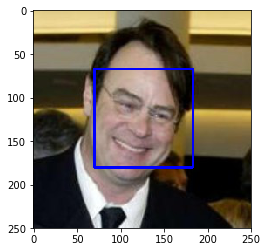

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
Percentage of the human face detection in first 100 images in human_files is: 98% <br>
Percentage of the human face detection in first 100 images in dog_files is: 17%

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_face_detection_humanFile = 0
human_face_detection_dogFile = 0
print("Answer:\n")
for img_path in tqdm(human_files_short):
    if face_detector(img_path):
        human_face_detection_humanFile += 1
print(f"Percentage of the human face detection in first 100 images in human_files is: {human_face_detection_humanFile}%")

for img_path2 in tqdm(dog_files_short):
    if face_detector(img_path2):
        human_face_detection_dogFile += 1
print(f"Percentage of the human face detection in first 100 images in dog_files is: {human_face_detection_dogFile}%")


  4%|▍         | 4/100 [00:00<00:02, 33.62it/s]

Answer:



  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of the human face detection in first 100 images in human_files is: 98%


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]

Percentage of the human face detection in first 100 images in dog_files is: 17%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:12<00:00, 45005235.22it/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    img = Image.open(img_path)
    
    #referrence: https://pytorch.org/docs/stable/torchvision/models.html
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])
    img_transformed = transform(img)
    if use_cuda:
        img_transformed = img_transformed.to('cuda')
    batch_tensor = torch.unsqueeze(img_transformed,0)
    VGG16.eval()
    output = VGG16(batch_tensor)
    output = output.to('cpu')
    #predicted_idx = output.data.numpy().argmax()
    predicted_idx = torch.argmax(output.data).item()
    #print(output.shape)
    #print(predicted_idx)
    #print(output[0,predicted_idx])
    return predicted_idx # predicted class index


In [8]:
VGG16_predict(dog_files_short[66])

236

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    predict_idx = VGG16_predict(img_path)
    result = (predict_idx >= 151) and (predict_idx <= 268)
    return result # true/false

In [10]:
dog_detector(dog_files_short[0])

True

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
Percentage of the dog detection in first 100 images in human_files is: 0% <br>
Percentage of the dog detection in first 100 images in dog_files is: 100%

In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
dog_detection_humanFile = 0
dog_detection_dogFile = 0

for img_path in tqdm(human_files_short):
    if dog_detector(img_path):
        dog_detection_humanFile += 1
print(f"Percentage of the dog detection in first 100 images in human_files is: {dog_detection_humanFile}%")

for img_path2 in tqdm(dog_files_short):
    if dog_detector(img_path2):
        dog_detection_dogFile += 1
print(f"Percentage of the dog detection in first 100 images in dog_files is: {dog_detection_dogFile}%")

  3%|▎         | 3/100 [00:00<00:03, 26.25it/s]

Percentage of the dog detection in first 100 images in human_files is: 0%


100%|██████████| 100/100 [00:04<00:00, 25.55it/s]

Percentage of the dog detection in first 100 images in dog_files is: 100%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [10]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#referrence: https://pytorch.org/docs/stable/torchvision/models.html
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

training_transforms = transforms.Compose([
    #transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize
])

validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

training_data = datasets.ImageFolder("/data/dog_images/train/",training_transforms)
validation_data = datasets.ImageFolder("/data/dog_images/valid/",validation_transforms)
test_data = datasets.ImageFolder("/data/dog_images/test/",test_transforms)

n_classes = len(training_data.classes)
batch_size = 20
num_workers = 0

training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                              num_workers=num_workers, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                                num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                                num_workers=num_workers, shuffle=True)
loaders_scratch = {"train" : training_loader, "valid" : validation_loader, "test" : test_loader} 

In [11]:
print(f"Number of training dataset: {len(training_data)}")
print(f"Number of validation dataset: {len(validation_data)}")
print(f"Number of testing dataset: {len(test_data)}")
print(f"Class length: {n_classes}")
#training_data.classes

Number of training dataset: 6680
Number of validation dataset: 835
Number of testing dataset: 836
Class length: 133


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:<br>

1. By reading the document about VGG16 https://neurohive.io/en/popular-networks/vgg16/ I learned that all ImageNet images are resized to 224 * 224 and use 3 color chanel RGB and resolution is 256 * 256. So I used CenterCrop(224) and Resize(256).

2. I used diferrent transforms for training images than validation and test images, because I want training dataset to be able to better trained for different images like flipped ones and also rotated images so that it can learn more aspects of the image. So I used Horizantal flip and rotated 10 degrees on top of resizing and random cropping for the training dataset.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [13]:
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [11]:
def weight_init_normal(m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            n = m.in_features
            y = (1/np.sqrt(n))
            m.weight.data.normal_(0,y)
            m.bias.data.fill_(0)

In [12]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3,16,3, padding =1)
        self.conv2 = nn.Conv2d(16,32,3, padding =1)
        self.conv3 = nn.Conv2d(32,64,3, padding =1)
        self.conv4 = nn.Conv2d(64,128,3, padding =1)
        self.conv5 = nn.Conv2d(128,256,3, padding =1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(256*7*7, 512)
        self.fc2 = nn.Linear(512, n_classes)
        self.dropout = nn.Dropout(0.25)
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        #print(x.shape)
        x = x.view(-1, 256*7*7)
        #x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
model_scratch.apply(weight_init_normal)
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ <br>
1. Choosing the number of convolution layers. I started with 3 layers 64->128->256 however it didn't help with reducing the training and validation loss, so I tried with 5 layers and used 16->32->64->128->256 filters, also I used 3 as convolution size and padding =1 and stride =1 by default. Max pooling is also used for sure to reduce the size of the feature set.<br>
2. I used 2*2 Maxpooling. <br>
3. Two fully connected Linear layer with output of n_classes which is 133 in my case. <br>
4. I used Relu activation for the forwarding. <br>
5. I applied dropt out rate of 25%. <br>
6. Choosing 512 as hidden layer input number, because I printed out the VGG16 model and analyzed the existing setup. <br>
7. Choosing the better learning rate. I fine tuned the lr and found that 0.1 works realy well for my model. By trying small lr like 0.001 or 0.01, training and validation loss didn't reduce at all for 10 epochs.
8. I also applied weight initilization to get better training result and it helped.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [13]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [14]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            #train_loss += loss.item() * data.size(0)
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        #train_loss = train_loss / len(loaders['train'].dataset)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output_v = model(data)
            loss_v = criterion(output_v, target)
            #valid_loss += loss_v.item() * data.size(0)
            valid_loss += ((1 / (batch_idx + 1)) * (loss_v.data - valid_loss))
        #valid_loss = valid_loss / len(loaders['valid'].dataset)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print(f" Lower validation loss was found and saved: {valid_loss}")
            valid_loss_min = valid_loss
            
    # return trained model
    return model


In [15]:
# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.883929 	Validation Loss: 4.864171
 Lower validation loss was found and saved: 4.864170551300049
Epoch: 2 	Training Loss: 4.868296 	Validation Loss: 4.866988
Epoch: 3 	Training Loss: 4.871366 	Validation Loss: 4.860889
 Lower validation loss was found and saved: 4.860888957977295
Epoch: 4 	Training Loss: 4.857706 	Validation Loss: 4.870989
Epoch: 5 	Training Loss: 4.852523 	Validation Loss: 4.810897
 Lower validation loss was found and saved: 4.810896873474121
Epoch: 6 	Training Loss: 4.788044 	Validation Loss: 4.693325
 Lower validation loss was found and saved: 4.693324565887451
Epoch: 7 	Training Loss: 4.736382 	Validation Loss: 4.618065
 Lower validation loss was found and saved: 4.618065357208252
Epoch: 8 	Training Loss: 4.672435 	Validation Loss: 4.503027
 Lower validation loss was found and saved: 4.503027439117432
Epoch: 9 	Training Loss: 4.598742 	Validation Loss: 4.432847
 Lower validation loss was found and saved: 4.432847023010254
Epoch: 10 	Traini

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [17]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.960398


Test Accuracy: 26% (224/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [31]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [32]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
#load the pretained resnet50 model
model_transfer = models.resnet50(pretrained=True)
#freeze the parameter of the pretrained model
for param in model_transfer.parameters():
    param.requires_grad = False
#replace the output layer with my n_classes 133 so that pretrained models output will match my expectation
n_features = model_transfer.fc.in_features #model_transfer.classifier[6].in_features
model_transfer.fc = nn.Linear(n_features ,n_classes)
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:10<00:00, 9973768.35it/s] 


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ <br>
1. I decided to choose Resnet50, since I used VGG16 when I built the model from scratch, for trasnfer learning I wanted to try other model and by reading the paper https://arxiv.org/abs/1512.03385 I decided to go with Resnet50.
2. once after loading the pretained Resenet50 model, I freezed all layers parameters.
3. By analyzing Resnet50 model, I learned that last output layer is named as "fc", so I updated that layer with my expected Linear layer which has ideal features amount 133
4. I used CrossEntropyLoss as loss function and Adam as optimizer. choosed the learning rate 0.001
5. when I was using both Adam and SGD, I got error from optimizor, after that I fixed by using filter that exclude the parameter that doesn't require gradients. I mentioned the source.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [33]:
criterion_transfer = nn.CrossEntropyLoss()

#reference: how to fix ValueError: optimizing a parameter that doesn't require gradients
# https://github.com/amdegroot/ssd.pytorch/issues/109
optimizer_transfer = optim.Adam(filter(lambda p: p.requires_grad,model_transfer.parameters()), 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [34]:
# train the model
n_epochs = 50
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, 
                       criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.721261 	Validation Loss: 0.881772
 Lower validation loss was found and saved: 0.881771981716156
Epoch: 2 	Training Loss: 1.465832 	Validation Loss: 0.678562
 Lower validation loss was found and saved: 0.6785618662834167
Epoch: 3 	Training Loss: 1.264989 	Validation Loss: 0.708241
Epoch: 4 	Training Loss: 1.173805 	Validation Loss: 0.628475
 Lower validation loss was found and saved: 0.6284753084182739
Epoch: 5 	Training Loss: 1.107965 	Validation Loss: 0.544985
 Lower validation loss was found and saved: 0.544984757900238
Epoch: 6 	Training Loss: 1.120298 	Validation Loss: 0.538420
 Lower validation loss was found and saved: 0.5384204387664795
Epoch: 7 	Training Loss: 1.084285 	Validation Loss: 0.527518
 Lower validation loss was found and saved: 0.5275184512138367
Epoch: 8 	Training Loss: 1.081548 	Validation Loss: 0.542668
Epoch: 9 	Training Loss: 1.036702 	Validation Loss: 0.550196
Epoch: 10 	Training Loss: 1.028349 	Validation Loss: 0.571638
Epoch: 11 	Tr

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [35]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.518255


Test Accuracy: 86% (720/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [36]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]   training_data
class_names = [item[4:].replace("_", " ") for item in training_data.classes]
               #data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    # normalize the image and then turn it into tensor same as VGG16_Predict() method
    #referrence: https://pytorch.org/docs/stable/torchvision/models.html
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])
    img_transformed = transform(img)
    if use_cuda:
        img_transformed = img_transformed.to('cuda')
    img_tensor = torch.unsqueeze(img_transformed,0)
    model_transfer.eval()
    output = model_transfer(img_tensor)
    output = output.to('cpu')
    predicted_idx = torch.argmax(output.data).item()
    
    return class_names[predicted_idx]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [39]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    fig = plt.figure(figsize=(16,4))
    dog_breed = predict_breed_transfer(img_path)
    #check if dog is detected first
    if dog_detector(img_path):
        print("\n\nHere we go! I recognized a cute dog!!!\n")
        # use model transfer to get breed name, index and dog name
        ax = fig.add_subplot(1,2,1)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        plt.axis('off')
        plt.show() 
        print("You look like ... " + dog_breed)
    elif face_detector(img_path):
        print("\n\nHello, human!!!\n")
        ax = fig.add_subplot(1,2,1)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        plt.axis('off')
        plt.show() 
        print("You look like ... " + dog_breed)
    else:
        print("Error ocurred during the claasification")
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)<br>
1. The output is much more better than I expected and it reached 86% accuracy.
2. I beleive that there are plenty of rooms to improve the accuracy by:
    a. fine tuning the learning rate. Because training the model takes long time so I was not able to try out more learning rate. Finietuning learning rate will improve the accuracy.
    b. In current model, I just changed the last output layer, I beleive if I use sequential method to raise the dropout rate and add another hidden layer, it might improve the accuracy as well.
    c. Last but not the least, I can improve data augmentation part by adding extra flipping etc.



Hello, human!!!



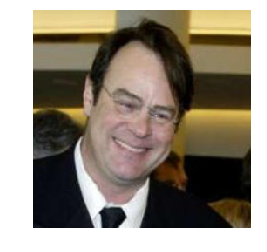

You look like ... Chihuahua


Hello, human!!!



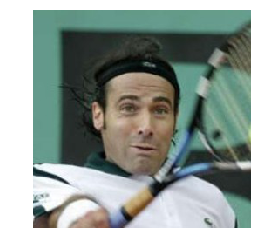

You look like ... American foxhound


Hello, human!!!



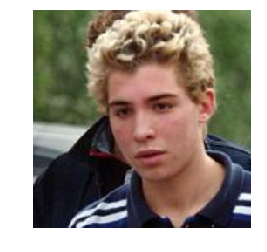

You look like ... Welsh springer spaniel


Here we go! I recognized a cute dog!!!



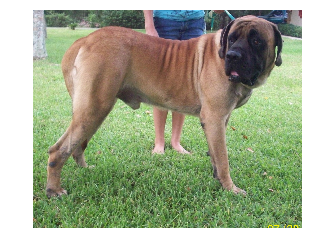

You look like ... Mastiff


Here we go! I recognized a cute dog!!!



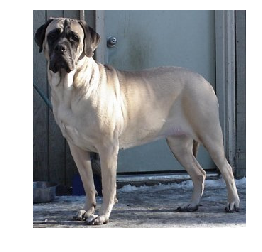

You look like ... Mastiff


Here we go! I recognized a cute dog!!!



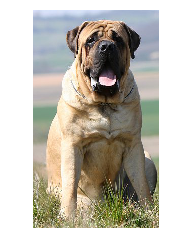

You look like ... Bullmastiff


In [40]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)